# Image classification via fine-tuning with EfficientNet

from: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

STEPS into fine tunning a pretrained model:
1. Select pretrained model and add custom layers on the top
2. Freeze the base
3. Train the custom layers first
    - !!!! You must train the added layers first and only then unfreze the base (step 4). Otherwise the error propagating could be too large
4. Unfreeze some base layers (few top layers, in order to adjust abstract features to our case in had)
    - !!!! Do not unfreeze BatchNormalization layers
5. Jointly train the whole network 
    - !!! You should consider lowering the learning rate in order to avoid destroying generic features too much (we want to adapt them to our case only)


### Load libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg16, EfficientNetB4
    # EfficientNetB4: 
        # This model takes input images of shape (224, 224, 3), 
        # and the input data should range [0, 255]. 
        # Normalization is included as part of the model.

from tensorflow.keras.models import Model,load_model

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, LeakyReLU
from tensorflow.keras.layers import concatenate, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization,Activation

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.random.set_seed(123)
from tensorflow.keras import backend as K

IMAGE_RES = (256,512) # H x W

### Load datasets

In [2]:
from scripts.generator_old import DataGenerator
from scripts.helper_functions import get_classes
from scripts.labels import labels

# Parameters
df_train = pd.DataFrame({'xPathLabel': ['/00 data/sample/aachen_000006_000019_leftImg8bit.png', 
                                   '/00 data/sample/aachen_000007_000019_leftImg8bit.png',
                                   '/00 data/sample/aachen_000008_000019_leftImg8bit.png'],                                 
                        'yPathLabel' : ['/00 data/sample/aachen_000006_000019_gtFine_color.png', 
                                    '/00 data/sample/aachen_000007_000019_gtFine_color.png',
                                    '/00 data/sample/aachen_000008_000019_gtFine_color.png']
                        })


data_dir = os.getcwd()
batch_size_min = min(1, len(df_train))

params = {'targetSize': (IMAGE_RES[1], IMAGE_RES[0]),
          'batchSize': batch_size_min,
          'augment': 1,
          'nbChannels': 3,
          'shuffle': True}

class_labels = get_classes(labels)
trainGen = DataGenerator(data_dir=data_dir,
                         data=df_train,
                         xPathLabel='xPathLabel',
                         yPathLabel='yPathLabel',
                         classes=class_labels,
                         **params)

testGen = DataGenerator(data_dir=data_dir,
                        data=df_train,
                        xPathLabel='xPathLabel',
                        yPathLabel='yPathLabel',
                        classes=class_labels,
                        **params)

### Helper func for block creation

In [3]:
def conv_block(tensor, nfilters, size=3, padding='same', 
               initializer="he_normal", nb_blocks=1):

    #add at least one, and if nb_blocks > 1 add others
    x = Conv2D(filters=nfilters, kernel_size=(size, size), 
                padding=padding, kernel_initializer=initializer
                )(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    for i in range(nb_blocks-1):
        x = Conv2D(filters=nfilters, kernel_size=(size, size), 
                    padding=padding, kernel_initializer=initializer
                    )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def deconv_block(tensor, residual, nfilters, size=3, 
                 padding='same', strides=(2, 2), nb_conv_blocks=2):

    y = Conv2DTranspose(nfilters, kernel_size=(size, size), 
                        strides=strides, padding=padding
                        )(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters, nb_blocks=nb_conv_blocks)
    return y

def get_multiple_outputs(model, only_first_blocks = True):
    # get all layers until the last one in the list (included)
    # define outputs for skip connections
    encoder_output_ids=[0,                           # 256 x 512 x 3
                        "block2a_expand_activation", # 128 x 256 x 144
                        "block3a_expand_activation", # 64 x 128 x 192 
                        "block4a_expand_activation", # 32 x 64 x 336
                        "block6a_expand_activation", # 16 x 32 x 960
                        ]

    if only_first_blocks == True:
      outputs = []
      # add first layer and then add layers in the list, names
      outputs.append(model.layers[0].output)

      for id in encoder_output_ids[1:]:
        outputs.append(model.get_layer(id).output)
  
      return Model(model.input, outputs)
    else:
      # get the whole model
      return Model(model.input, model.output)

def build_encoder():
  # use EfficientNet as encoder
    input_shape = (*IMAGE_RES, 3)
    inputs = Input(shape=input_shape)

    base_model = EfficientNetB4(include_top=False, 
                              weights='imagenet', 
                              # input_shape=input_shape
                              input_tensor=inputs
                              )

    only_first_blocks = True #if false, get entire model
    if only_first_blocks == True:
      encoder = get_multiple_outputs(base_model, only_first_blocks)
    else:
      encoder = get_multiple_outputs(base_model, only_first_blocks)

    return encoder

# EfficientNet Model Transfer Learning

In [4]:
def my_EfficientNet(num_classes=8, fine_tuning=False):
    CREATE_BOTTLENECK = True

    # down
    # input_layer = Input(shape=(*IMAGE_RES, 3), name='image_input')

    encoder = build_encoder()
    NB_UNFREEZE = len(encoder.layers)//5 #20% of the base network

    # x = encoder(input_layer)

    # freeze all the layers of the base model
    for layer in encoder.layers:
        layer.trainable = False

    if fine_tuning == True: # unfreeze some to adapt some generic features
        for layer in encoder.layers[-NB_UNFREEZE:]:
            # do not unfreeze Normalization layers, 
            # see here https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
            if not isinstance(layer, BatchNormalization):
                    layer.trainable =  True

    conv1_residual = encoder.outputs[0] # 256 512   3
    conv2_residual = encoder.outputs[1] # 128 256 144
    conv3_residual = encoder.outputs[2] #  64 128 192
    conv4_residual = encoder.outputs[3] #  32  64 336
    # last layer
    conv5_residual = encoder.outputs[4] #  16  32 960
    last_layer_shape = conv5_residual.shape[-3:]
    last_layer_nb_filters = conv5_residual.shape[-1]

    if CREATE_BOTTLENECK == True:
        bottleneck = conv_block(conv5_residual, last_layer_nb_filters)
    else:
        bottleneck = conv5_residual

    # up
    deconv6 = deconv_block(bottleneck, residual=conv4_residual, nfilters=960)
    # deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3_residual, nfilters=336)
    # deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2_residual, nfilters=192)
    deconv9 = deconv_block(deconv8, residual=conv1_residual, nfilters=144)
    
    # output
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    # output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    

    model = Model(inputs=encoder.input, outputs=output_layer, name='my_Unet')
    # model = Model(inputs=encoder.input, outputs=x, name='my_Unet')
    return model  

In [5]:
Model_ = my_EfficientNet(num_classes=8, fine_tuning=False)

if True==False:
    Model_.summary()

In [11]:
print(len(Model_.layers))

365


In [10]:
 Model_.summary()

Model: "my_Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [9]:
tf.keras.utils.plot_model(Model_, 
    to_file="model.png",
    dpi=96,)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [48]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
# Image(retina=True, filename='model_.png')

### model fine tuning

In [8]:
# # test fine tuning
# from scripts.model_and_metrics import my_EfficientNet
# import tensorflow as tf

# Model_ = my_EfficientNet(num_classes=8, fine_tuning=True)
# load checkpoint file inside checkpoint folder
# Model_.load_weights('model_azure/checkpoint/checkpoint')


In [9]:
from scripts.model_and_metrics import DiceLossCls, DiceMetric

Model_.compile(optimizer='rmsprop', 
                loss = DiceLossCls(), 
                metrics = [DiceMetric(num_classes=8)])

In [10]:
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="outputs/checkpoint", 
                              monitor='loss', 
                              save_best_only=True,
                              mode = 'auto',
                              save_weights_only=True)
                                

In [11]:
tf.config.run_functions_eagerly(True)


EPOCHS = 2
Model_.fit(trainGen.dataset, 
            validation_data=testGen.dataset,
            # use_multiprocessing=True,
            # workers=16,
            callbacks=[callbacks],
            epochs=EPOCHS,)

Epoch 1/2
3/3 [==============================] - 24s 9s/step - loss: 0.3751 - F1DiceMetric: 0.6297 - val_loss: 0.3684 - val_F1DiceMetric: 0.6516
Epoch 2/2
3/3 [==============================] - 30s 10s/step - loss: 0.2944 - F1DiceMetric: 0.6651 - val_loss: 0.3264 - val_F1DiceMetric: 0.5536


In [12]:
Model_.load_weights('outputs/checkpoint')

# Inference testing

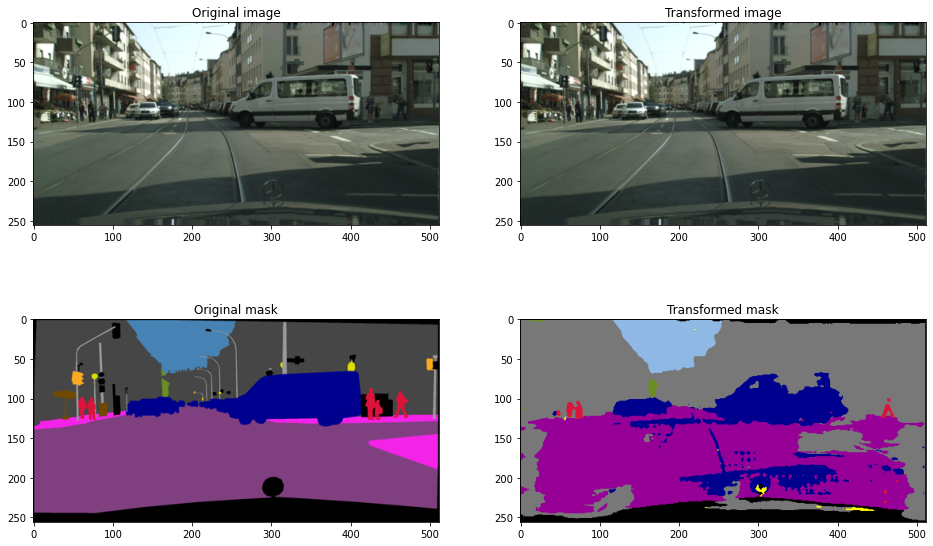

In [14]:
from PIL import Image
import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical
from scripts.helper_functions import get_classes, form_2D_label
from scripts.labels import labels

from scripts.helper_functions import label_to_mask, visualize
import matplotlib.pyplot as plt


mounted_drive = 'C:/Users/marko/Desktop/P8_dataset_small/'
class_labels = get_classes(labels)

x_img_path = 'images/val/frankfurt_000000_002196_leftImg8bit.png'
y_img_path =  'ground_truth/val/frankfurt_000000_002196_gtFine_color.png'


x_img = Image.open(mounted_drive + x_img_path).convert('RGB')
x_image = x_img.resize(IMAGE_RES[::-1])
x_array = np.array(x_image)


y_img = Image.open(mounted_drive + y_img_path).convert('RGB')
y_image = y_img.resize(IMAGE_RES[::-1])
y_array = np.array(y_image)
img_array_2D = form_2D_label(y_array, class_labels[0])
y_cat = to_categorical(img_array_2D, num_classes=8)

test_image = x_array

mask = Model_.predict(np.expand_dims(test_image, 0))[0]
mask = cv.resize(mask,IMAGE_RES[::-1])

visualize(cv.resize(test_image,IMAGE_RES[::-1]), 
          cv.resize(mask,IMAGE_RES[::-1]), 
          cv.resize(test_image,IMAGE_RES[::-1]), 
          cv.resize(y_array,IMAGE_RES[::-1]))
